In [2]:
const_pairs = pd.read_csv("../Data/const_pairs.csv")

In [3]:
df = const_pairs[const_pairs['region'] == 'London']
df.shape

(176, 4)

In [6]:
n = 'Bermondsey and Old Southwark'
df[(df['name1'] == n) | (df['name2'] == n)]

,region,pairing,name1,name2
253,London,254,Bermondsey and Old Southwark,Camberwell and Peckham
254,London,255,Bermondsey and Old Southwark,"Lewisham, Deptford"
255,London,256,Bermondsey and Old Southwark,Vauxhall


In [1]:
import geopandas
import numpy as np
import pandas as pd
# from shapely.geometry import Point


import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!pip install PyShp

     |████████████████████████████████| 215 kB 2.1 MB/s eta 0:00:01
  Created wheel for PyShp: filename=pyshp-2.1.0-py3-none-any.whl size=32607 sha256=07a59d22539189c494023fdf7bb9bbeac4d7879aceb9710fdfa02b4c9b8ca101
  Stored in directory: /home/jovyan/.cache/pip/wheels/a0/c5/f3/548a073ac6a83d5b23d9b39cdd24314fc84bc8afc9882deb33
Successfully built PyShp


In [3]:
import shapefile

In [4]:
sf = shapefile.Reader("../Data/gb_wpc_2010_05.shp")

In [5]:
s=set()
for record in sf.iterRecords():
    s.add(record[2])
s

{'Westminster Constituency'}

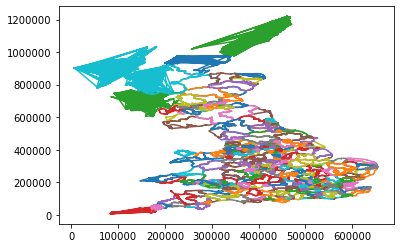

In [6]:
plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

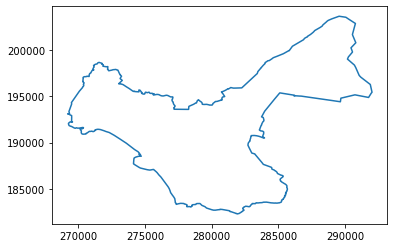

In [7]:
plt.figure()
shape = sf.shapeRecords()[0]
x = [i[0] for i in shape.shape.points[:]]
y = [i[1] for i in shape.shape.points[:]]
plt.plot(x,y)
plt.show()

In [8]:
shape.record[0]

'Aberavon Co Const'

In [9]:
shape.shape.parts

[0]

In [10]:
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['name', 'C', 60, 0],
 ['area_code', 'C', 3, 0],
 ['descriptio', 'C', 50, 0],
 ['file_name', 'C', 50, 0],
 ['number', 'N', 20, 0],
 ['number0', 'N', 20, 0],
 ['polygon_id', 'N', 20, 0],
 ['unit_id', 'N', 20, 0],
 ['code', 'C', 7, 0],
 ['hectares', 'N', 24, 15],
 ['area', 'N', 24, 15],
 ['type_code', 'C', 2, 0],
 ['descript0', 'C', 25, 0],
 ['type_cod0', 'C', 3, 0],
 ['descript1', 'C', 36, 0],
 ['label', 'C', 254, 0]]

In [11]:
import geopandas as gp

In [12]:
df = gp.read_file("../Data/Westminster_Parliamentary_Constituencies_December_2017_UK_BFC/Westminster_Parliamentary_Constituencies_December_2017_UK_BFC.shp")
df = df.rename(columns={"PCON17NM": "Name"})

Now let's scrape wikipedia for details about the UK constituencies, namely which region they are in

In [13]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

In [14]:
url = "https://en.wikipedia.org/wiki/United_Kingdom_Parliament_constituencies"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
constituencies_table = soup.findAll('table',{'class':'wikitable sortable'})

In [15]:
const_dict = {}
countries = ['England','Scotland','Wales','Northern Ireland']
for i in range(len(constituencies_table)):
    for items in constituencies_table[i].findAll('tr')[1:]:
        data = items.find_all(['th','td'])
        try:
            constituency = data[0].a.text
            electorate_2017 = data[1].text
            county = data[2].a.text
            if i == 0:
                region = data[3].text[:-1] # Remove the "\n"
            else:
                region = countries[i]
        except IndexError:pass
        const_dict[constituency] = pd.DataFrame.from_records(
            [{'constituency': constituency, 'electorate_2017': electorate_2017, 'county': county, 'region': region}] #, index=constituency
        )

In [16]:
const_df = pd.concat(const_dict).reset_index(drop=True)

In [17]:
# Bit of string replacement so that we can merge the datasets.
for i in range(len(const_df['constituency'])):
    const = const_df['constituency'][i]
    if 'St ' in const:
        const_df['constituency'][i] = str.replace(const_df['constituency'][i], "St ", "St. ")
    # Also need to remove the 'ô' in "Ynys Môn" 
    if 'ô' in const:
        const_df['constituency'][i] = str.replace(const_df['constituency'][i], "ô", "o")
# Now merge new information
# df['constituency'] = [x.rsplit(' ', 1)[0].rsplit(' ', 1)[0] for x in df['name']]
df = df.merge(const_df, left_on='Name', right_on='constituency')

In [18]:
df.sample(4)

,FID,PCON17CD,Name,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,constituency,electorate_2017,county,region
50,1,E14000530,Aldershot,484884,155126,-0.7841,51.2890,1.353165e+08,67449.222247,"POLYGON ((-0.77547 51.33196, -0.77533 51.33164...",Aldershot,"76,205",Hampshire,South East
75,76,E14000605,Bromsgrove,399840,273736,-2.0037,52.3617,5.812567e+08,185216.531838,"POLYGON ((-2.09328 52.44528, -2.09287 52.44504...",Bromsgrove,"73,571",Worcestershire,West Midlands
437,438,E14000967,Stalybridge and Hyde,398011,398062,-2.0314,53.4793,1.783009e+08,74440.328000,"POLYGON ((-1.96339 53.50983, -1.96430 53.50918...",Stalybridge and Hyde,"71,357",Greater Manchester,North West
151,162,E14000691,Enfield North,533311,198224,-0.0737,51.6670,9.677894e+07,56660.816053,"POLYGON ((-0.01192 51.68088, -0.01121 51.68087...",Enfield North,"68,474",London,London


In [19]:
# k = 0
# for i in range(len(df)):
#     iregion = df['region'][i]
#     for j in range(len(df)):
#         if i != j:
#             if (df['region'][j] == iregion):
#                 if not df.geometry[i].disjoint(df.geometry[j]):
#                     k += 1
# k

In [20]:
# The plan is to take every single constituency and find the 'neighbouring' constituency. 
# This will only be done on a region by region basis, as we are not interested in, say a Scotish constiuency that borders a North Easter England one.
# Create a pair and then see if we can use the Algorithm X to fit them into a region.
pair_const = {}
k = 0
for i in range(len(df)):
    iregion = df['region'][i]
    for j in range(i+1, len(df)):
        if (df['region'][j] == iregion):
            if not df.geometry[i].disjoint(df.geometry[j]):
                k += 1
                pair_const[k] = pd.DataFrame({'region': [iregion], 'pairing': k, 'name1': [df['Name'][i]], 'name2': [df['Name'][j]]})

In [21]:
const_pairs = pd.concat(pair_const).reset_index(drop=True)

In [175]:
# Now need to find all constituencies which haven't got a neighbouring constituency
paired_const = set(const_pairs['name1']).union(set(const_pairs['name2']))
unpaired_const = set(df['Name']).difference(paired_const)
# For the moment we will leave these out. 
# One reason is that 'Isle of Wight', 'Na h-Eileanan an Iar' and 'Orkney and Shetland' have protected status so that they have constituency
# boundaries defined exclusively by geography rather than by (or partly by) size of electorate.

{'Isle of Wight', 'Na h-Eileanan an Iar', 'Orkney and Shetland', 'Ynys Mon'}

In [189]:
np.unique(const_pairs['region'])

array(['East Midlands', 'Eastern', 'London', 'North East', 'North West',
       'Northern Ireland', 'Scotland', 'South East', 'South West',
       'Wales', 'West Midlands', 'Yorkshire & the Humber'], dtype=object)

In [171]:
paired_const

{'Aberavon',
 'Aberconwy',
 'Aberdeen North',
 'Aberdeen South',
 'Airdrie and Shotts',
 'Aldershot',
 'Aldridge-Brownhills',
 'Altrincham and Sale West',
 'Alyn and Deeside',
 'Amber Valley',
 'Angus',
 'Arfon',
 'Argyll and Bute',
 'Arundel and South Downs',
 'Ashfield',
 'Ashford',
 'Ashton-under-Lyne',
 'Aylesbury',
 'Ayr, Carrick and Cumnock',
 'Banbury',
 'Banff and Buchan',
 'Barking',
 'Barnsley Central',
 'Barnsley East',
 'Barrow and Furness',
 'Basildon and Billericay',
 'Basingstoke',
 'Bassetlaw',
 'Bath',
 'Batley and Spen',
 'Battersea',
 'Beaconsfield',
 'Beckenham',
 'Bedford',
 'Belfast East',
 'Belfast North',
 'Belfast South',
 'Belfast West',
 'Bermondsey and Old Southwark',
 'Berwick-upon-Tweed',
 'Berwickshire, Roxburgh and Selkirk',
 'Bethnal Green and Bow',
 'Beverley and Holderness',
 'Bexhill and Battle',
 'Bexleyheath and Crayford',
 'Birkenhead',
 'Birmingham, Edgbaston',
 'Birmingham, Erdington',
 'Birmingham, Hall Green',
 'Birmingham, Hodge Hill',
 'Birm

In [173]:
df.sample(4)

,FID,PCON17CD,Name,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,constituency,electorate_2017,county,region
438,439,E14000968,Stevenage,524285,223238,-0.19520,51.8938,1.662038e+08,102650.273411,"POLYGON ((-0.16218 51.92034, -0.16219 51.92034...",Stevenage,"70,597",Hertfordshire,Eastern
43,54,E14000583,Bosworth,439538,301379,-1.41750,52.6088,7.832201e+08,184420.193934,"POLYGON ((-1.28271 52.71464, -1.28283 52.71455...",Bosworth,"80,633",Leicestershire,East Midlands
497,468,E14000997,Tonbridge and Malling,561918,151566,0.31823,51.2403,7.658796e+08,212190.736690,"POLYGON ((0.30818 51.34279, 0.30844 51.34271, ...",Tonbridge and Malling,"74,877",Kent,South East
451,452,E14000981,Suffolk Coastal,635965,249452,1.44336,52.0931,2.002944e+09,709218.568189,"MULTIPOLYGON (((1.46373 52.04795, 1.46373 52.0...",Suffolk Coastal,"77,816",Suffolk,Eastern


In [22]:
const_pairs.sample(6)

,region,pairing,name1,name2
1024,South West,1025,North Dorset,West Dorset
504,London,505,Dulwich and West Norwood,Lewisham West and Penge
384,East Midlands,385,Charnwood,South Leicestershire
892,West Midlands,893,Ludlow,The Wrekin
485,North West,486,Copeland,Penrith and The Border
93,Yorkshire & the Humber,94,Beverley and Holderness,Kingston upon Hull East


In [328]:
y1 = [y for y in Y.values()]
s = set()
for i in range(len(y1)):
    [s.add(y2[0]) for y2 in zip(y1[i])]

In [330]:
len(s)

57

In [220]:
def all_solns(Y, region):
    all_solns = ExactCover(Y, random = True)
    i = 0
    for a in all_solns:
        i += 1
    print(f"For the {region} region there are {i} solutions when there are {len(X)} constituencies.")

In [222]:
region_name = 'Northern Ireland'
df2 = const_pairs[const_pairs['region'] == region_name]
Y = {}
X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
for i in range(len(df2)):
    Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}

import time
start = time.time()

all_solns(Y, region_name)

# all_solns = ExactCover(Y, random = True)
# i = 0
# for a in all_solns:
#     i += 1
#     #print(a)
# # n1 = next(all_solns)
# # n1
# print(f"There are {i} solutions when there are {len(X)} constituencies.")

end = time.time()
print("The time taken is ", end - start)


For the Northern Ireland region there are 129 solutions when there are 18 constituencies.
The time taken is  0.006987333297729492


In [224]:
region_name = 'North East'
df2 = const_pairs[const_pairs['region'] == region_name]
Y = {}
X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
# When looking at the North East. (or any region where we have an odd number of constituencies, we have to remove one)
# The random choice was 'Easington'
chosen = 'Easington'
df3 = df2[(df2['name1'] != chosen) & (df2['name2'] != chosen)]
X = set(np.unique(df3['name1'])).union(set(np.unique(df3['name2'])))
for i in range(len(df3)):
    Y[df3['pairing'].iloc[i]] = {df3['name1'].iloc[i], df3['name2'].iloc[i]}
# for i in range(len(df2)):
#     Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}
import time
start = time.time()
all_solns(Y, region_name)
end = time.time()
print("The time taken is ", end - start)
# columns = pd.unique(df2[['name1', 'name2']].values.ravel('K'))

# df3 = pd.DataFrame(columns={'region', *columns})
# df3 = df3[['region', *columns]]
# df3['region'] = df2['region']
# df3 = df3.fillna(0)#.reset_index(drop=True)
# for i in range(len(df2)):
#     df3.loc[df2.index[i], df2['name1'].iloc[i]] = 1
#     df3.loc[df2.index[i], df2['name2'].iloc[i]] = 1
# df3.sample(4)

For the North East region there are 44 solutions when there are 28 constituencies.
The time taken is  0.004656791687011719


In [225]:
region_name = 'Wales'
df2 = const_pairs[const_pairs['region'] == region_name]
Y = {}
X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
# When looking at Wales we still have to remove a constituency, since without Ynys Mon there are now 39 constituencies.
# The choice made was 'Arfon' since it has a small electorate
chosen = 'Arfon'
df3 = df2[(df2['name1'] != chosen) & (df2['name2'] != chosen)]
X = set(np.unique(df3['name1'])).union(set(np.unique(df3['name2'])))
for i in range(len(df3)):
    Y[df3['pairing'].iloc[i]] = {df3['name1'].iloc[i], df3['name2'].iloc[i]}
# for i in range(len(df2)):
#     Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}
start = time.time()
all_solns(Y, region_name)
end = time.time()
print("The time taken is ", end - start)

For the Wales region there are 16060 solutions when there are 38 constituencies.
The time taken is  0.5751402378082275


In [227]:
region_name = 'East Midlands'
df2 = const_pairs[const_pairs['region'] == region_name]

Y = {}
X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
for i in range(len(df2)):
    Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}
start = time.time()
all_solns(Y, region_name)
end = time.time()
print("The time taken is ", end - start)

For the East Midlands region there are 185837 solutions when there are 46 constituencies.
The time taken is  6.467477560043335


In [231]:
region_name = 'Yorkshire & the Humber'
df2 = const_pairs[const_pairs['region'] == region_name]

Y = {}
X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
for i in range(len(df2)):
    Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}
start = time.time()
all_solns(Y, region_name)
end = time.time()
print("The time taken is ", end - start)

For the Yorkshire & the Humber region there are 1042494 solutions when there are 54 constituencies.
The time taken is  41.565601110458374


In [251]:
region_name = 'South West'
df2 = const_pairs[const_pairs['region'] == region_name]

Y = {}
X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
# for i in range(len(df2)):
#     Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
# Have picked 'Stroud' at random
chosen = 'Stroud'
df3 = df2[(df2['name1'] != chosen) & (df2['name2'] != chosen)]
X = set(np.unique(df3['name1'])).union(set(np.unique(df3['name2'])))
for i in range(len(df3)):
    Y[df3['pairing'].iloc[i]] = {df3['name1'].iloc[i], df3['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}

start = time.time()
all_solns(Y, region_name)
end = time.time()
print("The time taken is ", end - start)

For the South West region there are 2727 solutions when there are 54 constituencies.
The time taken is  0.1697533130645752


In [254]:
region_name = 'Eastern'
df2 = const_pairs[const_pairs['region'] == region_name]

Y = {}
X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
for i in range(len(df2)):
    Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
# # Have picked 'Stroud' at random
# chosen = 'Stroud'
# df3 = df2[(df2['name1'] != chosen) & (df2['name2'] != chosen)]
# X = set(np.unique(df3['name1'])).union(set(np.unique(df3['name2'])))
# for i in range(len(df3)):
#     Y[df3['pairing'].iloc[i]] = {df3['name1'].iloc[i], df3['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}
start = time.time()
all_solns(Y, region_name)
end = time.time()
print("The time taken is ", end - start)

For the Eastern region there are 97178 solutions when there are 58 constituencies.
The time taken is  4.0193610191345215


In [268]:
region_name = 'West Midlands'
df2 = const_pairs[const_pairs['region'] == region_name]

Y = {}
# X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
for i in range(len(df2)):
    Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
# Have picked 'Dudley South' at random
chosen = 'Dudley South'
df3 = df2[(df2['name1'] != chosen) & (df2['name2'] != chosen)]
X = set(np.unique(df3['name1'])).union(set(np.unique(df3['name2'])))
for i in range(len(df3)):
    Y[df3['pairing'].iloc[i]] = {df3['name1'].iloc[i], df3['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}
# len(X)
start = time.time()
all_solns(Y, region_name)
end = time.time()
print("The time taken is ", end - start)

59

In [340]:
region_name = 'Scotland'
df2 = const_pairs[const_pairs['region'] == region_name]

Y = {}
X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
len(X)
for i in range(len(df2)):
    Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
# Have picked 'Glasgow North West' at random
chosen = 'Glasgow North West'
df3 = df2[(df2['name1'] != chosen) & (df2['name2'] != chosen)]
Y = {}
for i in range(len(df3)):
    Y[df3['pairing'].iloc[i]] = {df3['name1'].iloc[i], df3['name2'].iloc[i]}
y1 = [y for y in Y.values()]
# s = set()
# for i in range(len(y1)):
#     [s.add(y2[0]) for y2 in zip(y1[i])]
# print(len(s))
    
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}
start = time.time()
all_solns(Y, region_name)
end = time.time()
print("The time taken is ", end - start)

For the Scotland region there are 50413 solutions when there are 57 constituencies.
The time taken is  2.020097255706787


In [349]:
y1 = [y for y in Y.values()]
s = set()
for i in range(len(y1)):
    [s.add(y2[0]) for y2 in zip(y1[i])]
print(len(s))

72


Contact person who gave R talk, "Are PR and FPTP incompatible?"

In [350]:
region_name = 'London'
df2 = const_pairs[const_pairs['region'] == region_name]

Y = {}
# X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
for i in range(len(df2)):
    Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
# Have picked 'Lewisham West and Penge' at random
chosen = 'Lewisham West and Penge'
df3 = df2[(df2['name1'] != chosen) & (df2['name2'] != chosen)]
X = set(np.unique(df3['name1'])).union(set(np.unique(df3['name2'])))
Y = {}
for i in range(len(df3)):
    Y[df3['pairing'].iloc[i]] = {df3['name1'].iloc[i], df3['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}
start = time.time()
all_solns(Y, region_name)
end = time.time()
print("The time taken is ", end - start)

KeyboardInterrupt: 

In [345]:
random.choice(list(X.keys()))

'Lewisham West and Penge'

In [229]:
pd.value_counts(df['region'])

South East                84
North West                75
London                    73
Scotland                  59
West Midlands             59
Eastern                   58
South West                55
Yorkshire & the Humber    54
East Midlands             46
Wales                     40
North East                29
Northern Ireland          18
Name: region, dtype: int64

In [148]:
Y = {}
X = set(np.unique(df2['name1'])).union(set(np.unique(df2['name2'])))
# When looking at London. (or any region where we have an odd number of constituencies, we have to remove one)
# The random choice was 'Poplar and Limehouse'
chosen = 'Poplar and Limehouse'
df3 = df2[(df2['name1'] != chosen) & (df2['name2'] != chosen)]
X = set(np.unique(df3['name1'])).union(set(np.unique(df3['name2'])))
for i in range(len(df3)):
    Y[df3['pairing'].iloc[i]] = {df3['name1'].iloc[i], df3['name2'].iloc[i]}
# for i in range(len(df2)):
#     Y[df2['pairing'].iloc[i]] = {df2['name1'].iloc[i], df2['name2'].iloc[i]}
X = {j: set(filter(lambda i: j in Y[i], Y)) for j in X}
len(X)

72

In [99]:
%load_ext autoreload
%autoreload 2

In [149]:
# from importlib import reload
from algo_x import *

In [158]:
import time
start = time.time()

all_solns = ExactCover(Y, random = True)
i = 0
for a in all_solns:
    i += 1
    #print(a)
# n1 = next(all_solns)
# n1
print(f"There are {i} solutions when there are {len(X)} constituencies.")

end = time.time()
print(end - start)


There are 129 solutions when there are 18 constituencies.
0.009102821350097656


In [196]:
print("North East")
import time
start = time.time()

all_solns = ExactCover(Y, random = True)
i = 0
for a in all_solns:
    i += 1
    #print(a)
# n1 = next(all_solns)
# n1
print(f"There are {i} solutions when there are {len(X)} constituencies.")

end = time.time()
print(end - start)


North East
There are 22 solutions when there are 28 constituencies.
0.002165079116821289


In [208]:
print("Wales")
import time
start = time.time()

all_solns = ExactCover(Y, random = True)
i = 0
for a in all_solns:
    i += 1
    #print(a)
# n1 = next(all_solns)
# n1
print(f"There are {i} solutions when there are {len(X)} constituencies.")

end = time.time()
print(end - start)


Wales
There are 16060 solutions when there are 38 constituencies.
0.5895588397979736


In [211]:
print("East Midlands")
import time
start = time.time()

all_solns = ExactCover(Y, random = True)
i = 0
for a in all_solns:
    i += 1
    #print(a)
# n1 = next(all_solns)
# n1
print(f"There are {i} solutions when there are {len(X)} constituencies.")

end = time.time()
print(end - start)


East Midlands
There are 185837 solutions when there are 46 constituencies.
6.356137990951538


In [215]:
df[df['region'] == 'East Midlands'].shape

(46, 14)

In [217]:
pd.value_counts(df['region'])

South East                84
North West                75
London                    73
Scotland                  59
West Midlands             59
Eastern                   58
South West                55
Yorkshire & the Humber    54
East Midlands             46
Wales                     40
North East                29
Northern Ireland          18
Name: region, dtype: int64

In [76]:
choices = defaultdict(set)
unsatisfied = set(choices)
solution = []
best = min(unsatisfied, key=lambda j:len(choices[j]))
best

ValueError: min() arg is an empty sequence

In [75]:
unsatisfied

set()

In [51]:
def solve(X, Y, solution=[]):
    if not X:
        yield list(solution)
    else:
        c = min(X, key=lambda c: len(X[c]))
        for r in list(X[c]):
            solution.append(r)
            cols = select(X, Y, r)
            for s in solve(X, Y, solution):
                yield s
            deselect(X, Y, r, cols)
            solution.pop()

def select(X, Y, r):
    cols = []
    for j in Y[r]:
        for i in X[j]:
            for k in Y[i]:
                if k != j:
                    X[k].remove(i)
        cols.append(X.pop(j))
    return cols

def deselect(X, Y, r, cols):
    for j in reversed(Y[r]):
        X[j] = cols.pop()
        for i in X[j]:
            for k in Y[i]:
                if k != j:
                    X[k].add(i)

{1271: {'Belfast East', 'Belfast North'},
 1272: {'Belfast East', 'Belfast South'},
 1273: {'Belfast East', 'North Down'},
 1274: {'Belfast East', 'Strangford'},
 1275: {'Belfast North', 'Belfast South'},
 1276: {'Belfast North', 'Belfast West'},
 1277: {'Belfast North', 'East Antrim'},
 1278: {'Belfast North', 'South Antrim'},
 1279: {'Belfast South', 'Belfast West'},
 1280: {'Belfast South', 'Lagan Valley'},
 1281: {'Belfast South', 'Strangford'},
 1282: {'Belfast West', 'Lagan Valley'},
 1283: {'Belfast West', 'South Antrim'},
 1284: {'East Antrim', 'North Antrim'},
 1285: {'East Antrim', 'South Antrim'},
 1286: {'East Londonderry', 'Foyle'},
 1287: {'East Londonderry', 'Mid Ulster'},
 1288: {'East Londonderry', 'North Antrim'},
 1289: {'East Londonderry', 'West Tyrone'},
 1290: {'Fermanagh and South Tyrone', 'Mid Ulster'},
 1291: {'Fermanagh and South Tyrone', 'Newry and Armagh'},
 1292: {'Fermanagh and South Tyrone', 'Upper Bann'},
 1293: {'Fermanagh and South Tyrone', 'West Tyron

In [31]:
soln = solve(X, Y)

In [39]:
k = 0
for soln in solve(X, Y): 
    k += 1
    if k < 10:
        print(soln) 

['B', 'D', 'F']


In [157]:
df_count2 = pd.DataFrame({
    'X': [i for i in range(10)], 
    'A': [1,1,1,1,0,0,0,0,0,0],
    'B': [1,0,0,0,1,1,1,0,0,0],
    'C': [0,1,0,0,1,0,0,1,1,0],
    'D': [0,0,1,0,0,1,0,1,0,1],
    'E': [0,0,0,1,0,0,1,0,1,1]}
)
df_count2

,X,A,B,C,D,E
0,0,1,1,0,0,0
1,1,1,0,1,0,0
2,2,1,0,0,1,0
3,3,1,0,0,0,1
4,4,0,1,1,0,0
5,5,0,1,0,1,0
6,6,0,1,0,0,1
7,7,0,0,1,1,0
8,8,0,0,1,0,1
9,9,0,0,0,1,1


In [170]:
df_count.pivot_table(index='X', columns='Y', values='Z', aggfunc='count')

Y,A,B,C,D
X,,,,
0,1.0,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN
4,NaN,1.0,NaN,NaN
5,NaN,1.0,NaN,NaN
6,NaN,1.0,NaN,NaN
7,NaN,NaN,1.0,NaN
8,NaN,NaN,1.0,NaN


In [172]:
df_count.pivot_table(index='X', columns='Z', values='Y', aggfunc='count')

Z,B,C,D,E
X,,,,
0,1.0,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN
2,NaN,NaN,1.0,NaN
3,NaN,NaN,NaN,1.0
4,NaN,1.0,NaN,NaN
5,NaN,NaN,1.0,NaN
6,NaN,NaN,NaN,1.0
7,NaN,NaN,1.0,NaN
8,NaN,NaN,NaN,1.0


In [47]:
# df['name'][df['name'].apply(lambda x: 'Chipping' in x)] # the answer is 131
for i in range(len(df)):
    if not df.geometry[363].disjoint(df.geometry[i]):
        print(df['name'][i])

Blaenau Gwent Co Const
Brecon and Radnorshire Co Const
Filton and Bradley Stoke Co Const
Forest of Dean Co Const
Hereford and South Herefordshire Co Const
Monmouth Co Const
Newport East Co Const
Newport West Co Const
Torfaen Co Const


In [52]:
# df['name'][df['name'].apply(lambda x: 'Chipping' in x)] # the answer is 131
for i in range(len(df2)):
    if not df2.geometry[589].disjoint(df2.geometry[i]):
        print(df2['PCON17NM'][i])

Caithness, Sutherland and Easter Ross
Ross, Skye and Lochaber


In [51]:
df2[df2['PCON17NM'].str.contains('Caithness')]

,FID,PCON17CD,PCON17NM,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
589,560,S14000009,"Caithness, Sutherland and Easter Ross",258617,918473,-4.4027,58.1325,3.102805e+10,3.202050e+06,"MULTIPOLYGON (((-4.04392 57.73378, -4.04402 57..."


In [24]:
df2.sort_values('PCON17NM')

,FID,PCON17CD,PCON17NM,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
598,619,W07000049,Aberavon,281996,189115,-3.7047,51.5885,4.595283e+08,197276.207786,"MULTIPOLYGON (((-3.76071 51.53692, -3.76057 51..."
617,628,W07000058,Aberconwy,276098,360888,-3.8533,53.1307,1.675846e+09,346834.456141,"POLYGON ((-3.75654 53.31696, -3.75656 53.31695..."
581,552,S14000001,Aberdeen North,389796,808947,-2.1703,57.1712,1.610315e+08,104856.697097,"MULTIPOLYGON (((-2.07284 57.18942, -2.07278 57..."
582,553,S14000002,Aberdeen South,384133,802600,-2.2636,57.1141,2.787729e+08,160866.210335,"MULTIPOLYGON (((-2.07876 57.09300, -2.07895 57..."
583,554,S14000003,Airdrie and Shotts,283330,662650,-3.8647,55.8429,7.265862e+08,164813.823848,"POLYGON ((-3.74447 55.84022, -3.74446 55.84020..."
...,...,...,...,...,...,...,...,...,...,...
529,530,E14001059,Wythenshawe and Sale East,380730,389917,-2.2913,53.4057,1.026435e+08,68494.299874,"POLYGON ((-2.29970 53.43733, -2.29980 53.43711..."
540,531,E14001060,Yeovil,340522,114840,-2.8477,50.9299,1.008335e+09,242180.050981,"POLYGON ((-2.58426 50.97889, -2.58648 50.97793..."
590,611,W07000041,Ynys Mon,245222,378346,-4.3229,53.2794,1.995674e+09,604396.054217,"MULTIPOLYGON (((-4.45561 53.16241, -4.45575 53..."
541,532,E14001061,York Central,459887,451276,-1.0889,53.9541,6.773449e+07,60016.166779,"POLYGON ((-1.08727 53.98139, -1.08659 53.98097..."


In [12]:
df = gp.read_file("../Data/gb_wpc_2010_05.shp")

In [13]:
df.head(10)

,name,area_code,descriptio,file_name,number,number0,polygon_id,unit_id,code,hectares,area,type_code,descript0,type_cod0,descript1,label,geometry
0,Aberavon Co Const,WMC,Westminster Constituency,ABERAVON_CO_CONST,1.0,2.0,70318.0,24881.0,999999,18652.410,924.619,VA,CIVIL VOTING AREA,None,None,24881,"POLYGON ((280739.900 194603.100, 280746.900 19..."
1,Aberconwy Co Const,WMC,Westminster Constituency,ABERCONWY_CO_CONST,1.0,2.0,122457.0,24852.0,999999,62267.111,1852.838,VA,CIVIL VOTING AREA,None,None,24852,"POLYGON ((267631.000 354236.500, 267573.700 35..."
2,Aberdeen North Burgh Const,WMC,Westminster Constituency,ABERDEEN_NORTH_BURGH_CONST,1.0,2.0,121719.0,33486.0,999999,5691.085,945.450,VA,CIVIL VOTING AREA,None,None,33486,"POLYGON ((384027.400 806411.400, 384415.400 80..."
3,Aberdeen South Burgh Const,WMC,Westminster Constituency,ABERDEEN_SOUTH_BURGH_CONST,1.0,4.0,86776.0,33487.0,999999,9247.245,1015.833,VA,CIVIL VOTING AREA,None,None,33487,"MULTIPOLYGON (((378240.500 802083.600, 378237...."
4,Airdrie and Shotts Co Const,WMC,Westminster Constituency,AIRDRIE_AND_SHOTTS_CO_CONST,1.0,2.0,121842.0,33927.0,999999,22943.914,0.000,VA,CIVIL VOTING AREA,None,None,33927,"POLYGON ((274977.100 672604.600, 274979.700 67..."
5,Aldershot Boro Const,WMC,Westminster Constituency,ALDERSHOT_BORO_CONST,1.0,2.0,70075.0,25022.0,999999,5298.349,0.000,VA,CIVIL VOTING AREA,None,None,25022,"POLYGON ((483481.800 152923.700, 483479.100 15..."
6,Aldridge-Brownhills Boro Const,WMC,Westminster Constituency,ALDRIDGE-BROWNHILLS_BORO_CONST,1.0,2.0,119930.0,24629.0,999999,4399.803,0.000,VA,CIVIL VOTING AREA,None,None,24629,"POLYGON ((404009.200 299236.400, 404006.100 29..."
7,Altrincham and Sale West Boro Const,WMC,Westminster Constituency,ALTRINCHAM_AND_SALE_WEST_BORO_CONST,1.0,2.0,70266.0,24649.0,999999,5093.492,0.000,VA,CIVIL VOTING AREA,None,None,24649,"POLYGON ((368282.000 388925.800, 368290.100 38..."
8,Alyn and Deeside Co Const,WMC,Westminster Constituency,ALYN_AND_DEESIDE_CO_CONST,1.0,2.0,70255.0,24660.0,999999,15689.567,202.577,VA,CIVIL VOTING AREA,None,None,24660,"POLYGON ((321605.100 357730.100, 321616.200 35..."
9,Amber Valley Co Const,WMC,Westminster Constituency,AMBER_VALLEY_CO_CONST,1.0,2.0,70564.0,24766.0,999999,12463.899,0.000,VA,CIVIL VOTING AREA,None,None,24766,"POLYGON ((439005.700 342789.000, 438980.200 34..."


In [14]:
# df['name'][df['name'].apply(lambda x: 'Chipping' in x)] # the answer is 131
for i in range(len(df)):
    if not df.geometry[131].disjoint(df.geometry[i]):
        print(df['name'][i])

Chipping Barnet Boro Const
Enfield, Southgate Boro Const
Finchley and Golders Green Boro Const
Hendon Boro Const
Hertsmere Co Const
Hornsey and Wood Green Boro Const


Now let's scrape wikipedia for details about the UK constituencies, namely which region they are in

In [15]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

In [16]:
url = "https://en.wikipedia.org/wiki/United_Kingdom_Parliament_constituencies"
response = requests.get(url)

In [17]:
soup = BeautifulSoup(response.text, "html.parser")

In [18]:
# soup.findAll('h3')
constituencies_table = soup.findAll('table',{'class':'wikitable sortable'})

In [19]:
const_dict = {}
countries = ['England','Scotland','Wales','Northern Ireland']
for i in range(len(constituencies_table)):
    for items in constituencies_table[i].findAll('tr')[1:]:
        data = items.find_all(['th','td'])
        try:
            constituency = data[0].a.text
            electorate_2017 = data[1].text
            county = data[2].a.text
            if i == 0:
                region = data[3].text[:-1] # Remove the "\n"
            else:
                region = countries[i]
        except IndexError:pass
        const_dict[constituency] = pd.DataFrame.from_records(
            [{'constituency': constituency, 'electorate_2017': electorate_2017, 'county': county, 'region': region}] #, index=constituency
        )

In [20]:
const_df = pd.concat(const_dict).reset_index(drop=True)

In [21]:
const_df.sample(10)

,constituency,electorate_2017,county,region
29,Birkenhead,"64,484",Merseyside,North West
322,North Thanet,"72,657",Kent,South East
524,Worsley and Eccles South,"72,177",Greater Manchester,North West
640,Lagan Valley,"71,152",Lisburn,Northern Ireland
484,Wansbeck,"60,705",Northumberland,North East
347,Penrith and The Border,"65,139",Cumbria,North West
238,Kensington,"60,594",London,London
179,Gateshead,"65,186",Tyne and Wear,North East
315,North East Hertfordshire,"75,967",Hertfordshire,Eastern
547,Dundee East,"67,822",Angus,Scotland


In [22]:
pd.value_counts(const_df['region'])

South East                84
North West                75
London                    73
Scotland                  59
West Midlands             59
Eastern                   58
South West                55
Yorkshire & the Humber    54
East Midlands             46
Wales                     40
North East                29
Northern Ireland          18
Name: region, dtype: int64

Need to add on a dot to the end of 'St' (e.g. 'Bury St. Edmunds') to provide compatibility to the previous data set.

In [24]:
df.columns

Index(['name', 'area_code', 'descriptio', 'file_name', 'number', 'number0',
       'polygon_id', 'unit_id', 'code', 'hectares', 'area', 'type_code',
       'descript0', 'type_cod0', 'descript1', 'label', 'geometry'],
      dtype='object')

In [25]:
for i in range(len(const_df['constituency'])):
    const = const_df['constituency'][i]
    if 'St ' in const:
        const_df['constituency'][i] = str.replace(const_df['constituency'][i], "St ", "St. ")
    # Also need to remove the 'ô' in "Ynys Môn" 
    if 'ô' in const:
        const_df['constituency'][i] = str.replace(const_df['constituency'][i], "ô", "o")
# Now merge new information
df['constituency'] = [x.rsplit(' ', 1)[0].rsplit(' ', 1)[0] for x in df['name']]
df = df.merge(const_df)

The region chosen is East Midlands


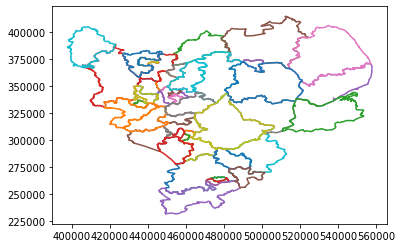

In [35]:
regions = np.unique(df['region'])
region = np.random.choice(regions, 1)
print(f"The region chosen is {region[0]}")
constituencies = np.array(df['name'][df['region'] == region[0]])
plt.figure()
for shape in sf.shapeRecords():
    if shape.record[0] in constituencies:
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x,y)
plt.show()

In [36]:
london_df = const_df[const_df['region'] == 'London']

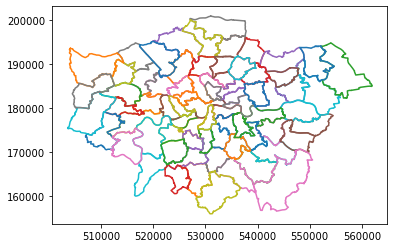

In [37]:
constituencies = np.array(df['name'][df['region'] == 'London'])
plt.figure()
for shape in sf.shapeRecords():
    if shape.record[0] in constituencies:
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x,y)
plt.show()

In [38]:
london_df.shape

(73, 4)

In [ ]:
const_df[const_df['region'] == "Wales"].tail(6)

In [165]:
const_df.to_csv('../Data/scraped_wikipedia.csv', index=False)

In [35]:
np.sum(df['constituency'].isin(const_df['constituency']))

632

In [30]:
w = df['constituency'].isin(const_df['constituency'])

In [31]:
df['constituency'][df['constituency'].isin(const_df['constituency']) == False]

629    Ynys Mon
Name: constituency, dtype: object

In [32]:
const_df['constituency'][const_df['constituency'].isin(df['constituency']) == False]

631                      Ynys Môn
632                  Belfast East
633                 Belfast North
634                 Belfast South
635                  Belfast West
636                   East Antrim
637              East Londonderry
638    Fermanagh and South Tyrone
639                         Foyle
640                  Lagan Valley
641                    Mid Ulster
642              Newry and Armagh
643                  North Antrim
644                    North Down
645                  South Antrim
646                    South Down
647                    Strangford
648                    Upper Bann
649                   West Tyrone
Name: constituency, dtype: object